# Data-Prep: CRM Data

# Load libs

In [1]:

# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
parent_dir = file_dir.parent
sys.path.append(str(parent_dir))

import pandas as pd
pd.options.display.max_columns = None


## Libraries & Settings ##
from pa_lib.file import load_bin
from pa_lib.util import cap_words
from pa_lib.log import time_log, info

import datetime as dt
from dateutil.relativedelta import relativedelta

from pa_lib.data import (
    clean_up_categoricals,
    unfactorize,
)

from pa_lib.data import desc_col

In [2]:
from pa_lib.data import boxplot_histogram
import numpy as np


# Load CRM data

In [3]:
def load_crm_data():
    raw_data = load_bin("vkprog\\crm_data_vkprog.feather").rename(
        mapper=lambda name: cap_words(name, sep="_"), axis="columns"
    )
    return raw_data.astype({"Year": "int64", "KW_2": "int64"})


In [4]:
raw_crm_data = load_crm_data()

2019-10-09 16:17:03 [INFO] Started loading binary file
2019-10-09 16:17:03 [INFO] Reading from file C:\Users\stc\data\vkprog\crm_data_vkprog.feather
2019-10-09 16:17:03 [INFO] Finished loading binary file in 0.26s (0.45s CPU)


In [5]:
#raw_crm_data.eval("YYYYKW_2 = Year * 100 + KW_2", inplace=True)

# View raw crm data

In [9]:
raw_crm_data.sample(n=5, random_state=42)

,Betreff,Kanal,Datum,Quelle,Verantwortlich,Kuerzel,Endkunde_NR,VB_Filter_Von,VB_Filter_Bis,VB_Filter_Grund,Year,KW,KW_2,KW_4
208857,KAM & Ost - City ePanels Winterthur - Einladung,E-Mail,2014-08-22,Marketing,Jasmine Meier (REGION OST ZÜRICH),JHU,137079,NaT,NaT,NaN,2014,34,33,33
104293,Suivi offres en cours et confirmations,Telefon,2019-09-30,Verkauf,Vito Rao (TRAFFIC ROMANDIE),VRA,118604,NaT,NaT,NaN,2019,40,39,37
295002,Offre d'affichage CDNV - 930410,E-Mail,2017-12-12,Verkauf,Claudie Dovat (REGION WEST GENF),DCL,412272,NaT,NaT,NaN,2017,50,49,49
260630,Mitte - Aktionen - 2014 - KMU-NAZKW28-30,E-Mail,2014-05-19,Marketing,Maja Loosli (REGION VERKAUF MITTE),MAL,165971,NaT,NaT,NaN,2014,21,21,21
690801,Mitte - Aktionen - 2013 - KMU-Aktion KW50-52_2013,E-Mail,2013-10-25,Marketing,Manfred Birbaum (REGION VERKAUF MITTE),BIM,580317,NaT,NaT,NaN,2013,43,43,41


In [37]:
display(raw_crm_data.pivot_table(
                        index=["Quelle","Kanal"],
                        columns=["Year"],
                        values=["Endkunde_NR"],
                        aggfunc="count",
                        fill_value=0) )

Endkunde_NR                                       \
Year                                2013   2014   2015    2016   2017    2018   
Quelle         Kanal                                                            
Contact Center E-Mail                  0      0      0       0      0      17   
Marketing      Brief                2824   7136   3149    5729   2393    3196   
               E-Mail               9409  48391  63441  112053  96470  104512   
               Event                   0    164     98     674    848     601   
               Telefon                 0      0      0       0      0     821   
               Veranstaltung           0      0      0       0      0      17   
Verkauf        Besprechung            85    171    179     749    547     213   
               Besuch               2406  10941  11944   12302  11974   10922   
               Brief                  98    376    515     576    978     677   
               Dankeskarte             0     68     76      82     77      72   
               E-Mail               5786  25558  33931   46054  50604   54386   
               Event                  51     59      1       0      0       0   
               Fax                     0      1      1       4      5       2   
               Internet               23     85     99     112    127      88   
               SMS                     1      8      6      17     10       8   
               Telefon               927   4942   9424    7388   7644    7296   
               Twitter                 0      2      0       0      0       0   
               Veranstaltung           0    238    375     200     84      99   

                                                              
Year                           2019 2020 2021 2022 2023 2024  
Quelle         Kanal                                          
Contact Center E-Mail             1    0    0    0    0    0  
Marketing      Brief           1941    0    0    0    0    0  
               E-Mail         66739    0    0    0    0    0  
               Event              0    0    0    0    0    0  
               Telefon            0    0    0    0    0    0  
               Veranstaltung      0    0    0    0    0    0  
Verkauf        Besprechung      118    0    0    0    0    0  
               Besuch          7989   52    0    0    1    0  
               Brief            449    0    0    0    0    0  
               Dankeskarte       47    0    0    0    0    0  
               E-Mail         37471    1    1    1    1    1  
               Event              0    0    0    0    0    0  
               Fax                0    0    0    0    0    0  
               Internet          74    0    0    0    0    0  
               SMS                5    0    0    0    0    0  
               Telefon         4651   17    0    0    0    0  
               Twitter            0    0    0    0    0    0  
               Veranstaltung     68    0    0    0    0    0

In [53]:
temp_df =raw_crm_data.pivot_table(
                        index=["Kanal"],
                        columns=["Quelle"],
                        values=["Endkunde_NR"],
                        aggfunc="count",
                        fill_value=0)

In [54]:
import seaborn as sns
import matplotlib.pyplot  as plt
sns.set_style("darkgrid")

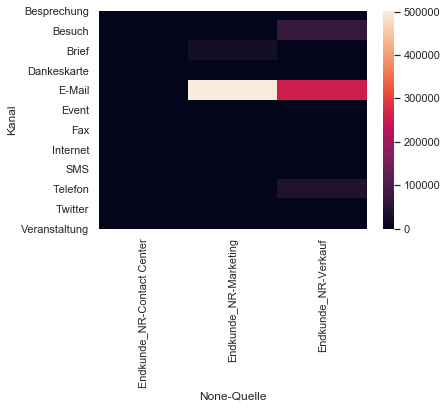

In [57]:
#plt.figure(figsize=(20,15))
sns.heatmap(temp_df)#,annot=True, fmt="d")

# Define Groups

In [11]:
from functools import reduce

all_kanal =set(raw_crm_data.loc[:,"Kanal"])
kanal_grps = {}

kanal_grps["Besprechung"]         = {"Besprechung"}
kanal_grps["Besuch"]              = {"Besuch"}
kanal_grps["Brief_Dankeskarte"]   = {"Brief","Dankeskarte"}
kanal_grps["E-Mail"]              = {"E-Mail"}
kanal_grps["Event_Veranstaltung"] = {"Event","Veranstaltung"}
kanal_grps["Telefon"]             = {"Telefon"}

# Stuff all the rest into "Anderes":
kanal_grps["Anderes"]             =  all_kanal - reduce(set.union,kanal_grps.values())  

# Yearly aggregation per ``Kanal`` group element

In [12]:
def contacts_grouped_yrly(date_view,kanal_grps,year_span):
    ####
    def yrl_kanal_contacts(date_view, group_name, rel_year):
        return (raw_crm_data.loc[(raw_crm_data.loc[:,"Kanal"].isin(kanal_grps[group_name]) &     # adjust to key
                         (raw_crm_data.loc[:,"Datum"] <  date_view  - relativedelta(years= rel_year   )) &
                         (raw_crm_data.loc[:,"Datum"] >= date_view  - relativedelta(years= rel_year+1 )) # adjust years
                         ),:]
                    .groupby("Endkunde_NR").count()
                    .reset_index(inplace=False)
                    .loc[:,["Endkunde_NR","Kanal"]]
                    .rename(columns={"Kanal": f"RY_{rel_year}_Anz_{group_name}"})   # adjust "Anzahl"
                    #.sort_values("Anzahl", ascending=False)
               )
    #####
    container_df = yrl_kanal_contacts(date_view=date_view,
                                      group_name=list(kanal_grps.keys())[1],rel_year=0).loc[:,"Endkunde_NR"]
    for name in kanal_grps.keys():
        for i in range(year_span):
            rel = yrl_kanal_contacts(date_view=date_view,
                                     group_name=name,
                                     rel_year=i)
            container_df = pd.merge(container_df,
                                    rel,
                                    on="Endkunde_NR",
                                    how="inner")
    return container_df

## Delta(view_date, last_contact)

In [36]:
def delta_contact(date_view,kanal_grps):
    for name in kanal_grps.keys():
        raw_crm_data.loc[raw_crm_data.Kanal.isin(kanal_grps[name]), "Kanal_Grps"] = name
    
    max_vertical_df = (raw_crm_data.loc[(raw_crm_data.loc[:,"Datum"] <  date_view) # adjust years
                     ,:]
                .groupby(["Endkunde_NR", "Kanal_Grps"])
                .agg({"Datum": np.max})
                .reset_index(inplace=False)
                   )
    max_vertical_df["delta_days"] = (date_view - max_vertical_df.loc[:,"Datum"]).apply(lambda x: x.total_seconds()) / 86400  # delta in days
    
    flatten_df = max_vertical_df.pivot_table(
        index      = "Endkunde_NR",
        columns    = ["Kanal_Grps"],
        values     = ["delta_days"],
        aggfunc    = "min",
        fill_value = np.inf # for the moment!
    
    ).reset_index(inplace=False)
    
    flatten_df  = pd.DataFrame(flatten_df.to_records(index=False))
    flatten_df.columns = ["Endkunde_NR"]+[ "Letzter_Kontakt_Delta_"+x.replace("'","").replace("(","").replace("delta_days, ","").replace(",","").replace(" ","").replace(")","") for x in flatten_df.columns[1:]]
    
    flatten_df["Letzter_Kontakt_Delta_global"] = flatten_df.iloc[:,1:].min(axis = 1, skipna = True)
    
    #Letzte_Buchung_Delta
    
    return flatten_df

# Wrapper Function, that does everything in one go!

In [27]:
def crm_train_scoring(day, month, year_score, year_train, year_span):
    date_now      = dt.datetime(year_score,month,day) # only works for odd calendar weeks!!!
    date_training = dt.datetime(year_train,month,day) # only works for odd calendar weeks!!!
    
    def crm_prep(date_view,year_span):
        last_contacts_df      = delta_contact(date_view=date_view,
                                              kanal_grps=kanal_grps)
        grpd_yrly_contacts_df = contacts_grouped_yrly(date_view=date_view,
                                                      kanal_grps=kanal_grps,
                                                      year_span=year_span)

        return pd.merge(grpd_yrly_contacts_df,last_contacts_df,on="Endkunde_NR",how="inner")
    
    crm_train_df = crm_prep(date_view=date_training, year_span=year_span)
    crm_score_df = crm_prep(date_view=date_now,      year_span=year_span)
    
    return (crm_train_df, crm_score_df)
    
    

# Testing Wrapper-Function

In [28]:
crm_train_df, crm_score_df = crm_train_scoring(day=23,
                                               month=9,
                                               year_score=2019,
                                               year_train=2018,
                                               year_span=4)

In [29]:
crm_train_df.sample(n=3, random_state=1)

,Endkunde_NR,RY_0_Anz_Besprechung,RY_1_Anz_Besprechung,RY_2_Anz_Besprechung,RY_3_Anz_Besprechung,RY_0_Anz_Besuch,RY_1_Anz_Besuch,RY_2_Anz_Besuch,RY_3_Anz_Besuch,RY_0_Anz_Brief_Dankeskarte,RY_1_Anz_Brief_Dankeskarte,RY_2_Anz_Brief_Dankeskarte,RY_3_Anz_Brief_Dankeskarte,RY_0_Anz_E-Mail,RY_1_Anz_E-Mail,RY_2_Anz_E-Mail,RY_3_Anz_E-Mail,RY_0_Anz_Event_Veranstaltung,RY_1_Anz_Event_Veranstaltung,RY_2_Anz_Event_Veranstaltung,RY_3_Anz_Event_Veranstaltung,RY_0_Anz_Telefon,RY_1_Anz_Telefon,RY_2_Anz_Telefon,RY_3_Anz_Telefon,RY_0_Anz_Anderes,RY_1_Anz_Anderes,RY_2_Anz_Anderes,RY_3_Anz_Anderes,Letzter_Kontakt_Delta_Anderes,Letzter_Kontakt_Delta_Besprechung,Letzter_Kontakt_Delta_Besuch,Letzter_Kontakt_Delta_Brief_Dankeskarte,Letzter_Kontakt_Delta_E-Mail,Letzter_Kontakt_Delta_Event_Veranstaltung,Letzter_Kontakt_Delta_Telefon,Letzter_Kontakt_Delta_global
33114,597160,0,0,0,0,0,0,0,0,0,0,1,0,6,3,2,0,0,0,0,0,0,0,1,0,0,0,0,0,inf,inf,inf,978.0,20.0,inf,881.0,20.0
7439,170610,0,0,0,0,6,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,inf,inf,6.0,inf,20.0,inf,inf,6.0
44493,642961,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,inf,inf,inf,inf,103.0,inf,inf,103.0


In [33]:
def lazy_bxplt_hstgrm(delta_contacts_df):
    for name in delta_contacts_df.columns[1:]:
        print(name)
        boxplot_histogram(delta_contacts_df.loc[delta_contacts_df.loc[:,name] < np.inf, name])

In [34]:
desc_col(crm_train_df)

,DTYPE,NULLS,UNIQUE
Endkunde_NR,object,0/45316,45316
RY_0_Anz_Besprechung,int64,0/45316,10
RY_1_Anz_Besprechung,int64,0/45316,19
RY_2_Anz_Besprechung,int64,0/45316,13
RY_3_Anz_Besprechung,int64,0/45316,7
RY_0_Anz_Besuch,int64,0/45316,29
RY_1_Anz_Besuch,int64,0/45316,28
RY_2_Anz_Besuch,int64,0/45316,28
RY_3_Anz_Besuch,int64,0/45316,26
RY_0_Anz_Brief_Dankeskarte,int64,0/45316,8


RY_0_Anz_Besprechung


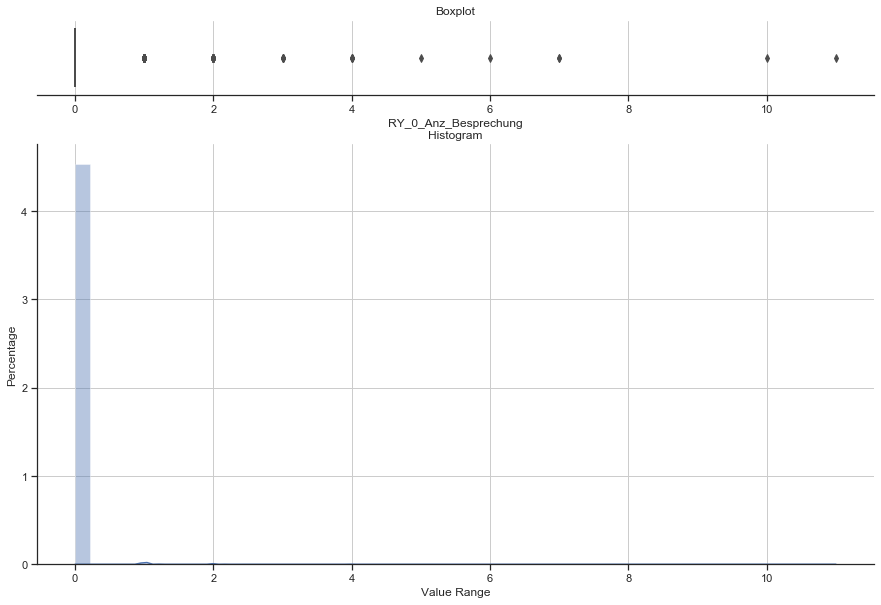

RY_1_Anz_Besprechung


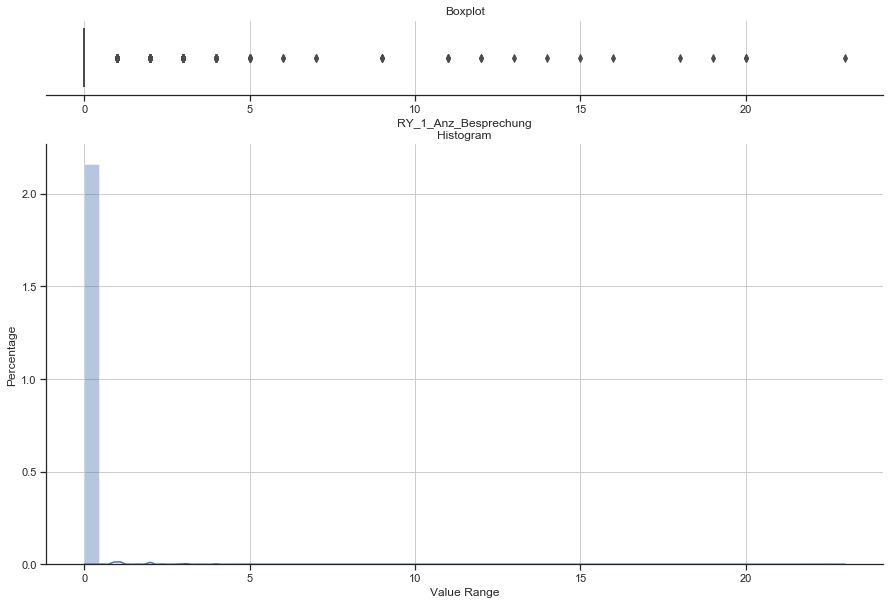

RY_2_Anz_Besprechung


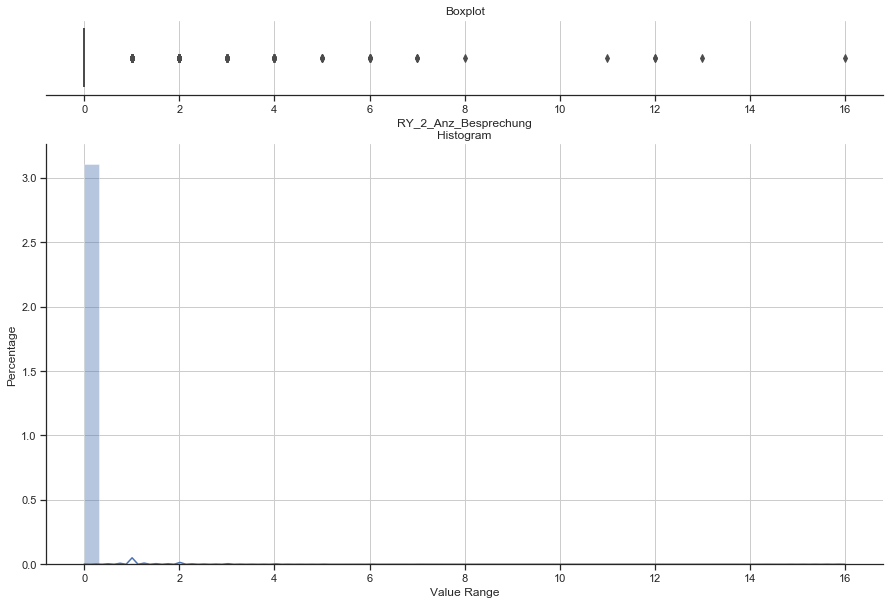

RY_3_Anz_Besprechung


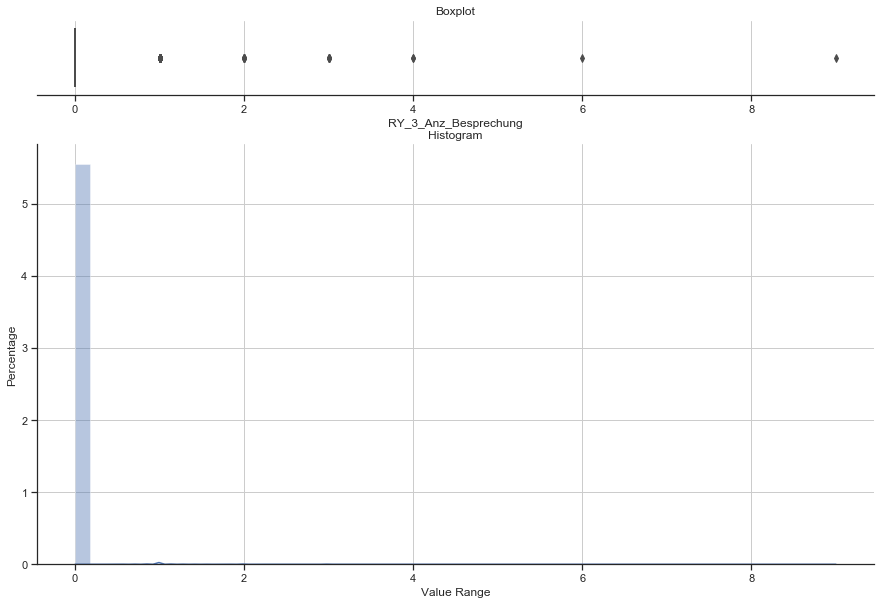

RY_0_Anz_Besuch


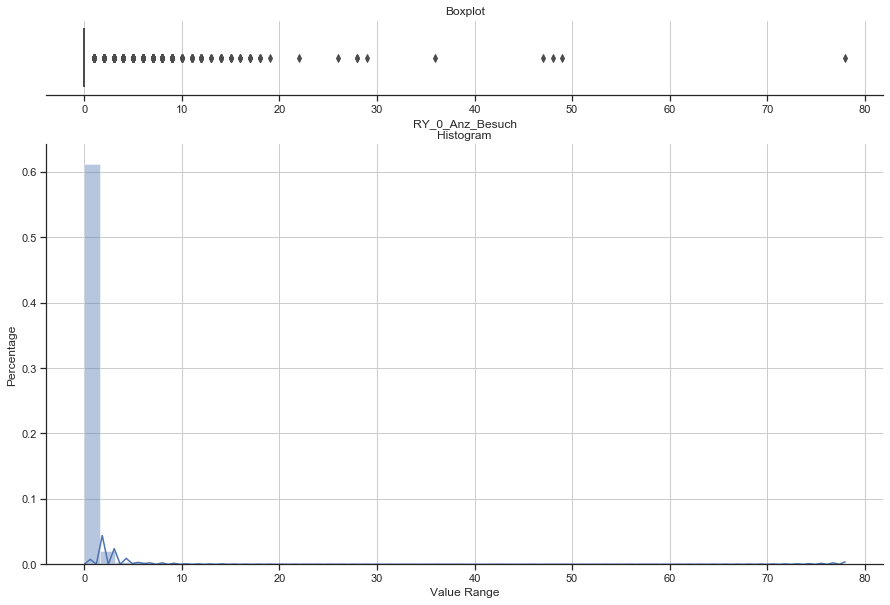

RY_1_Anz_Besuch


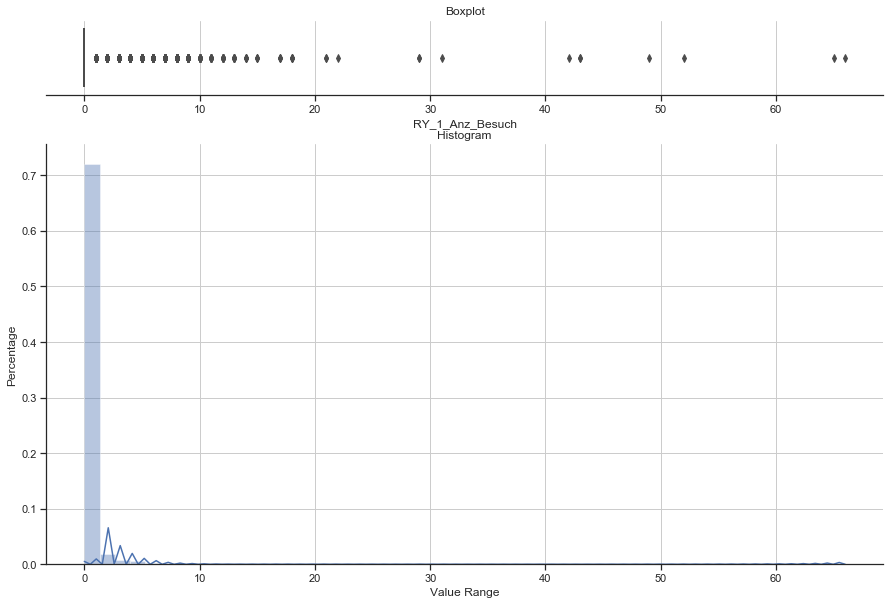

RY_2_Anz_Besuch


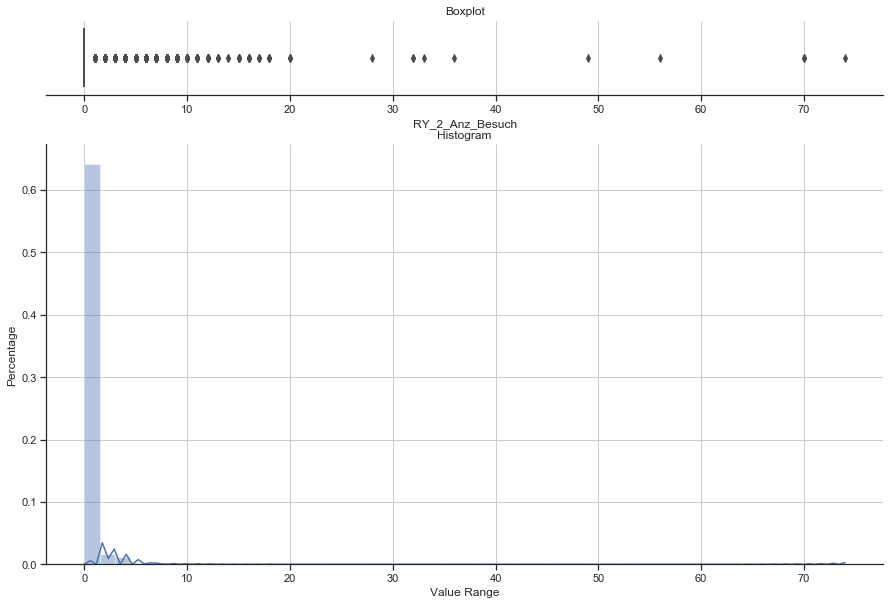

RY_3_Anz_Besuch


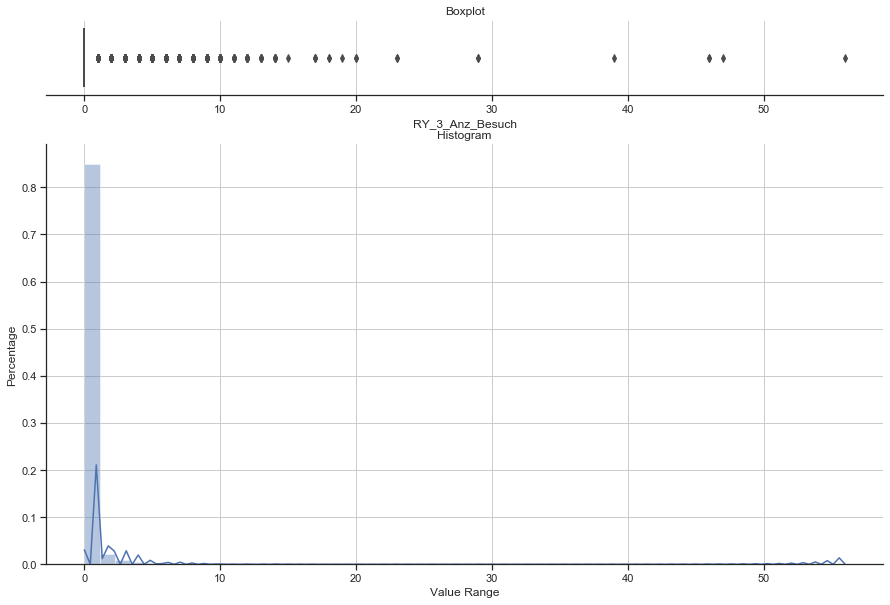

RY_0_Anz_Brief_Dankeskarte


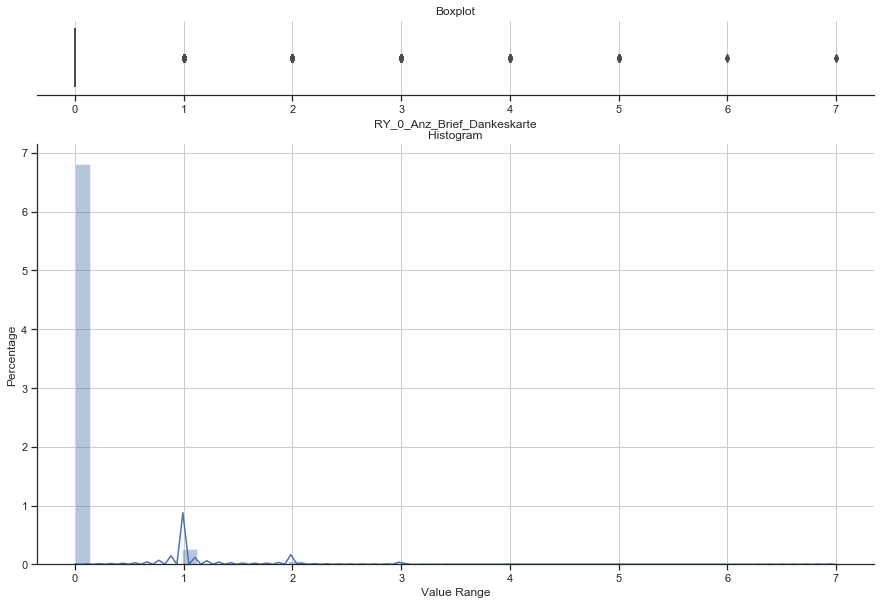

RY_1_Anz_Brief_Dankeskarte


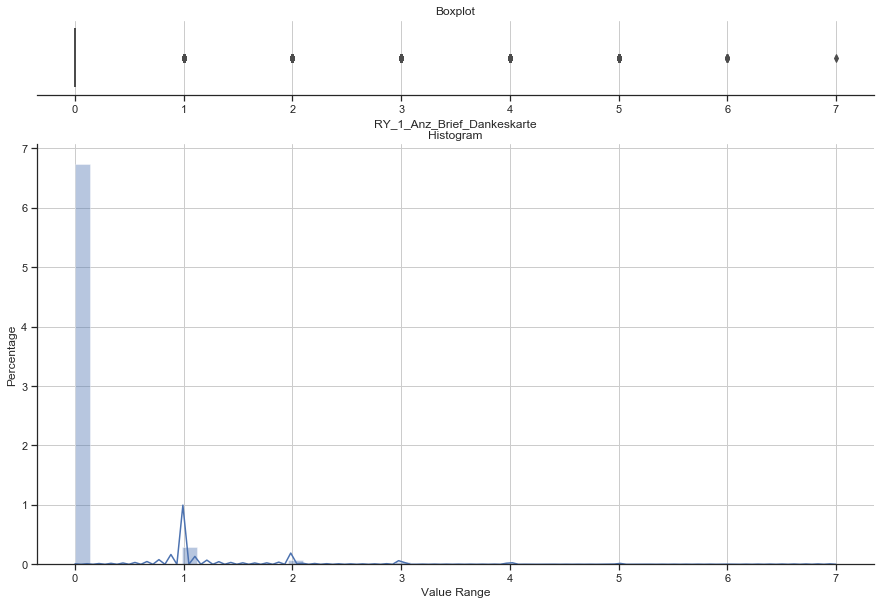

RY_2_Anz_Brief_Dankeskarte


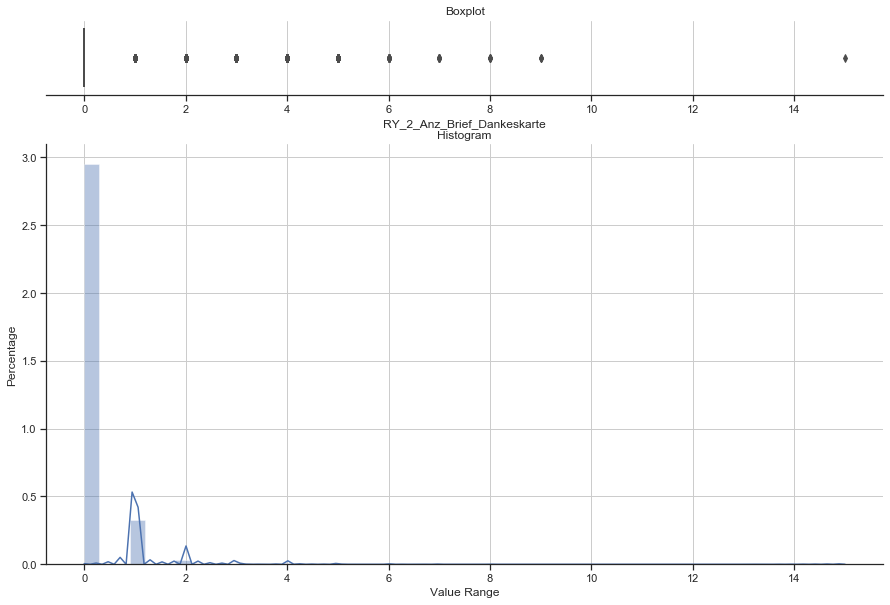

RY_3_Anz_Brief_Dankeskarte


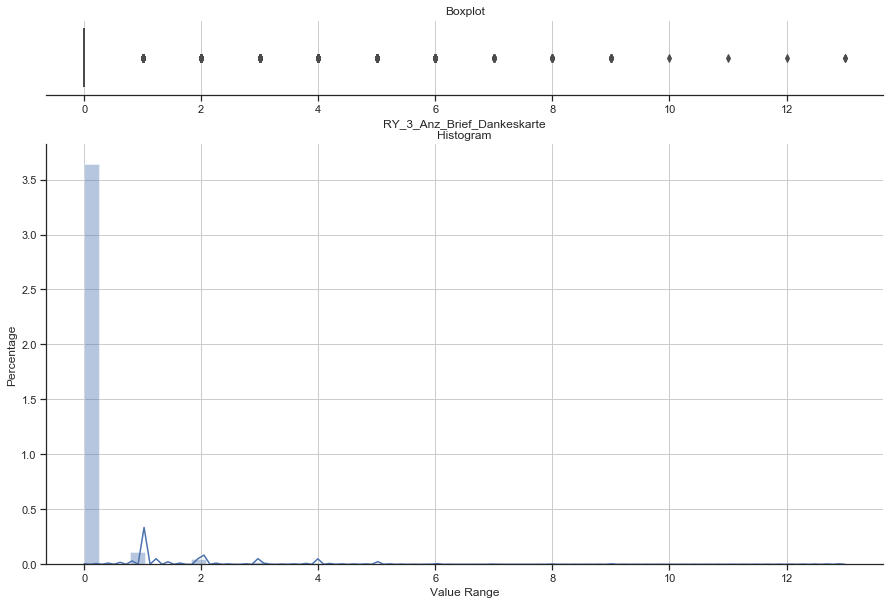

RY_0_Anz_E-Mail


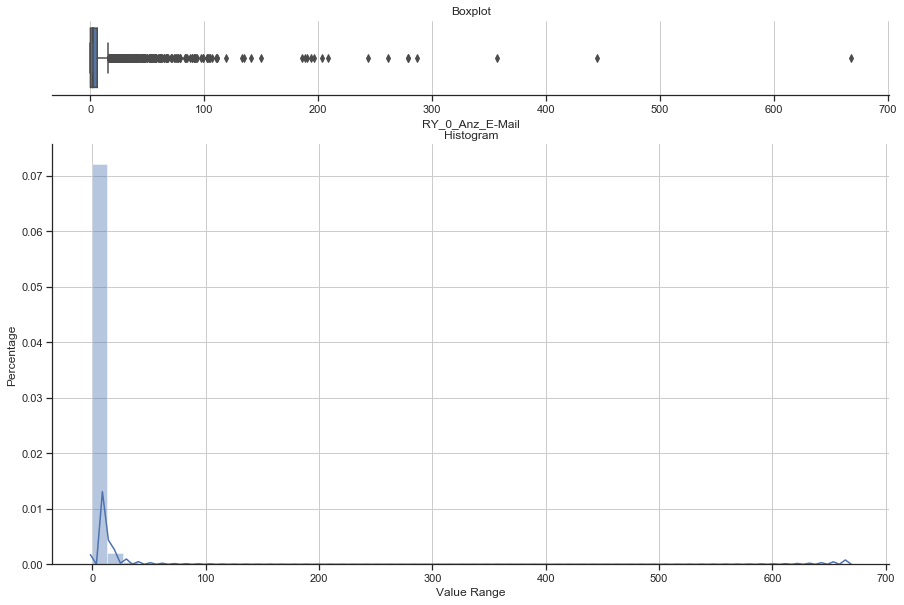

RY_1_Anz_E-Mail


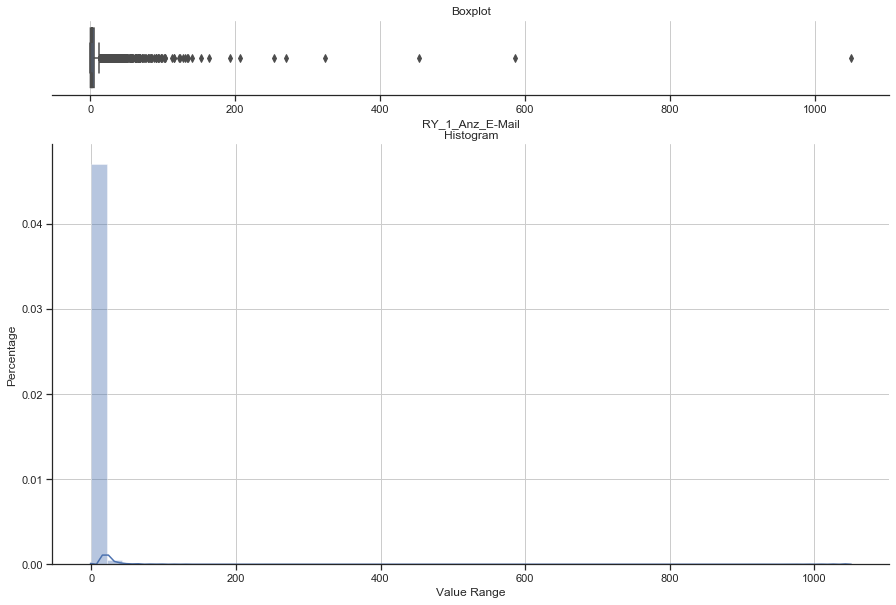

RY_2_Anz_E-Mail


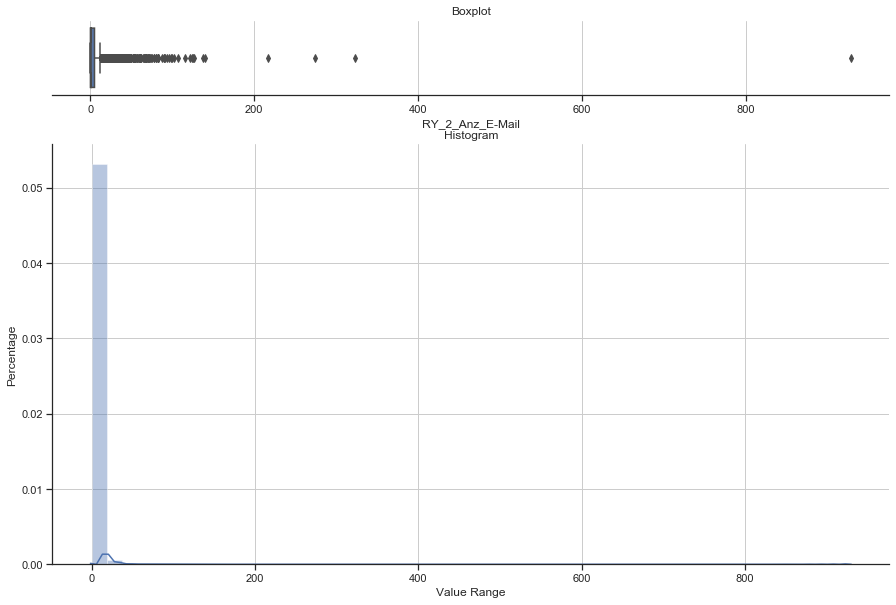

RY_3_Anz_E-Mail


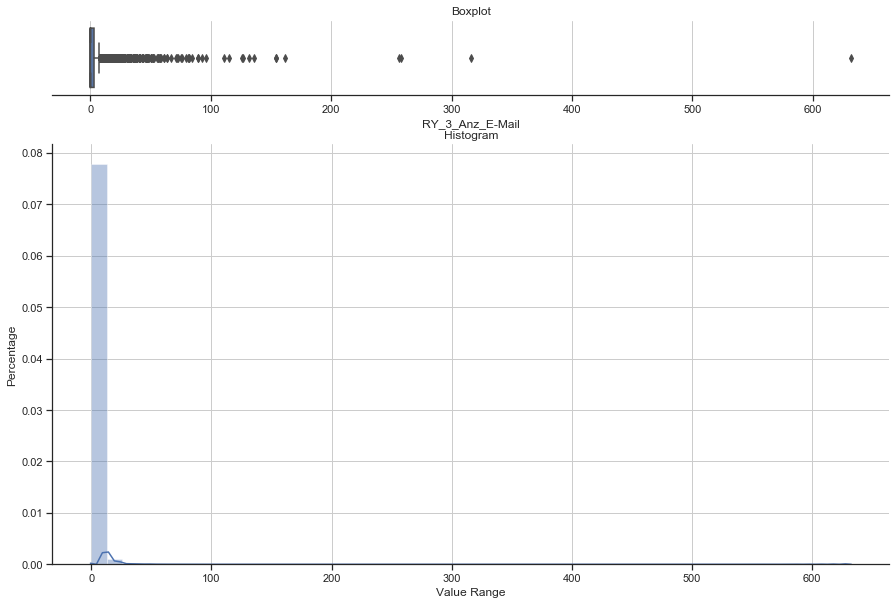

RY_0_Anz_Event_Veranstaltung


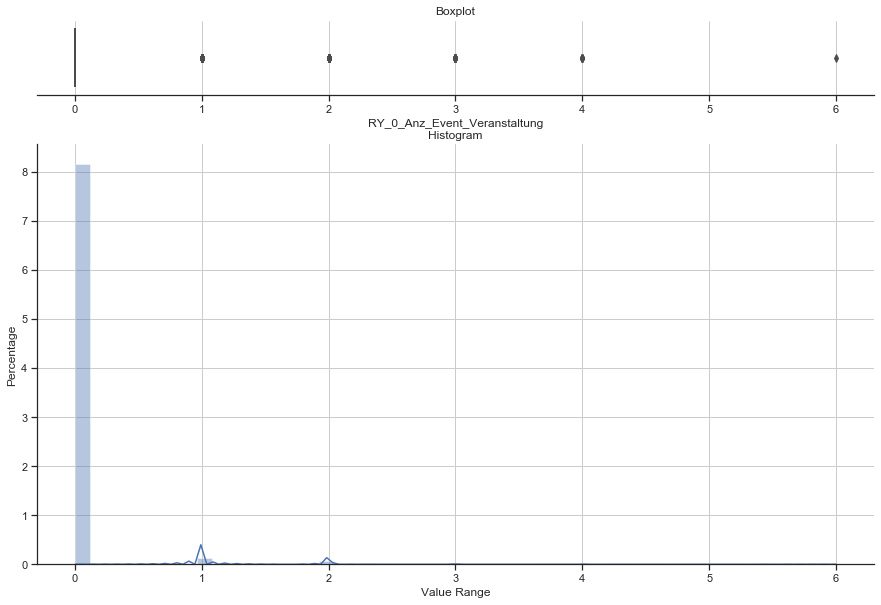

RY_1_Anz_Event_Veranstaltung


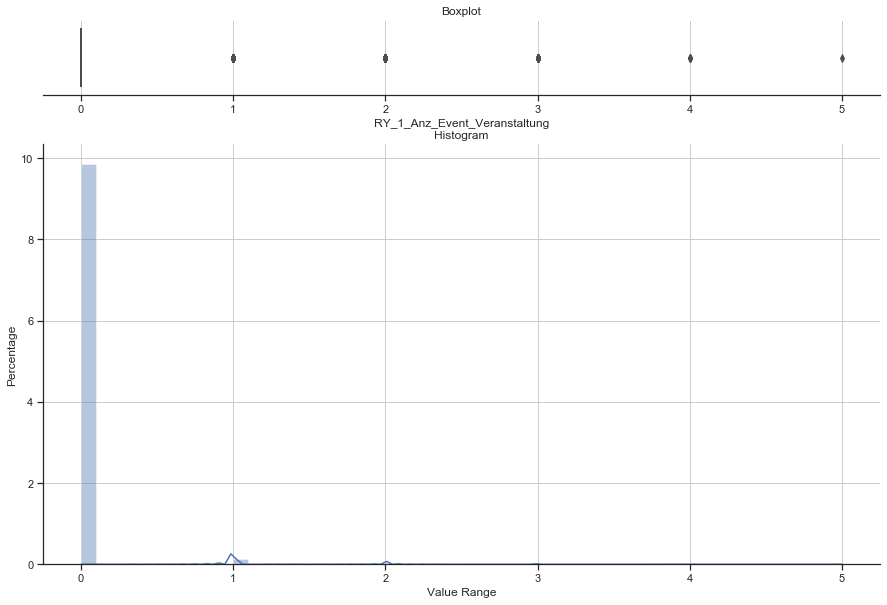

RY_2_Anz_Event_Veranstaltung


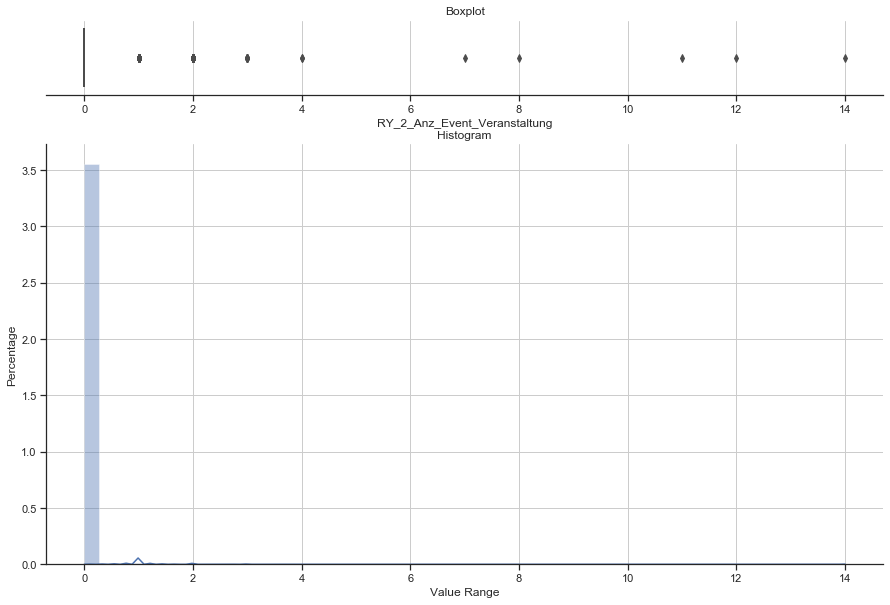

RY_3_Anz_Event_Veranstaltung


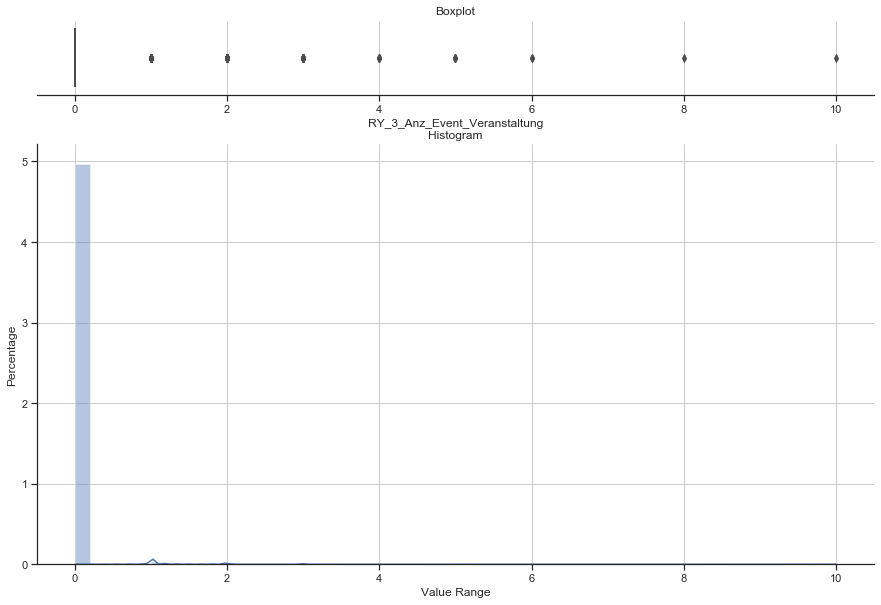

RY_0_Anz_Telefon


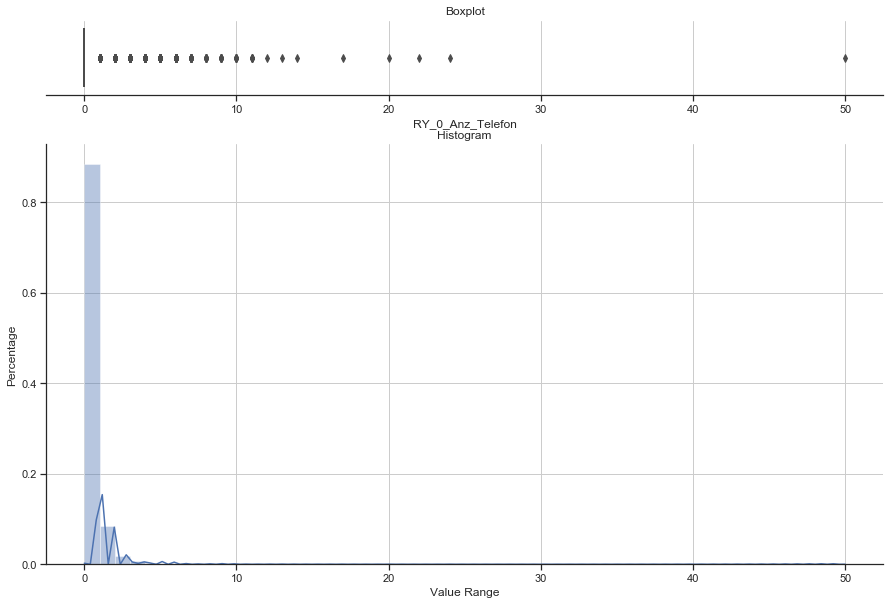

RY_1_Anz_Telefon


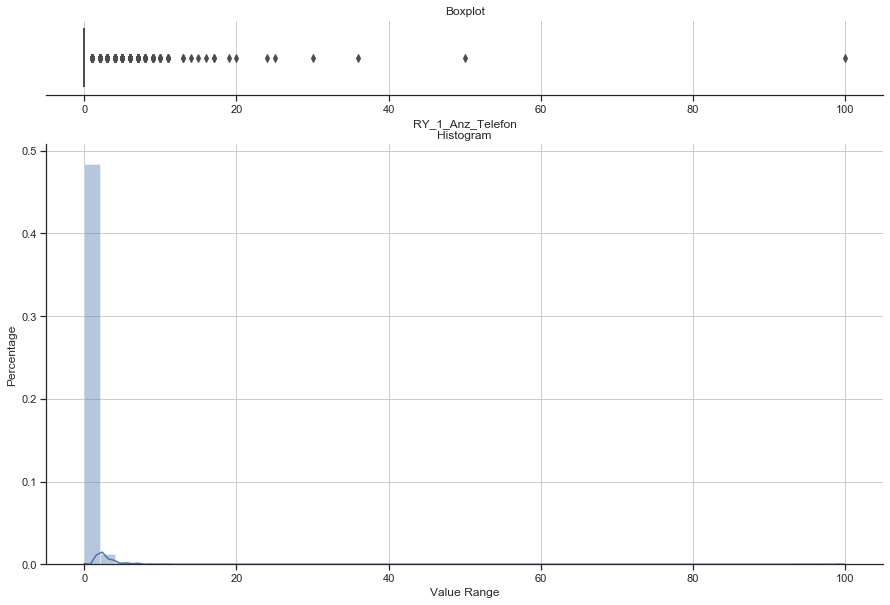

RY_2_Anz_Telefon


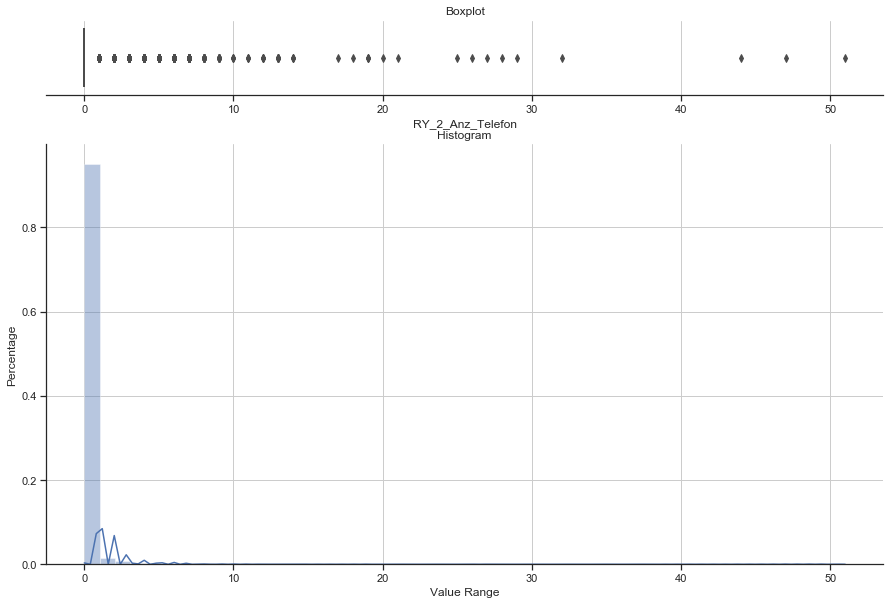

RY_3_Anz_Telefon


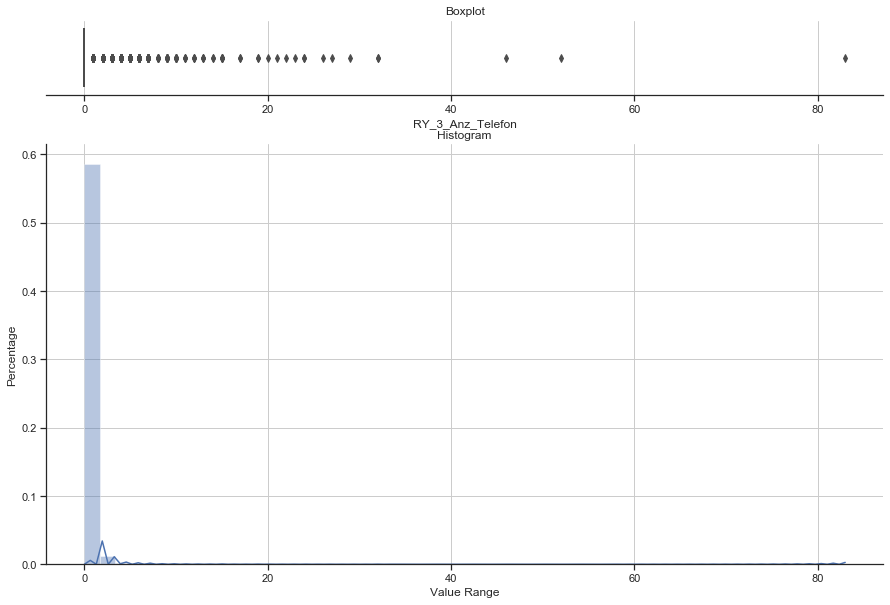

RY_0_Anz_Anderes


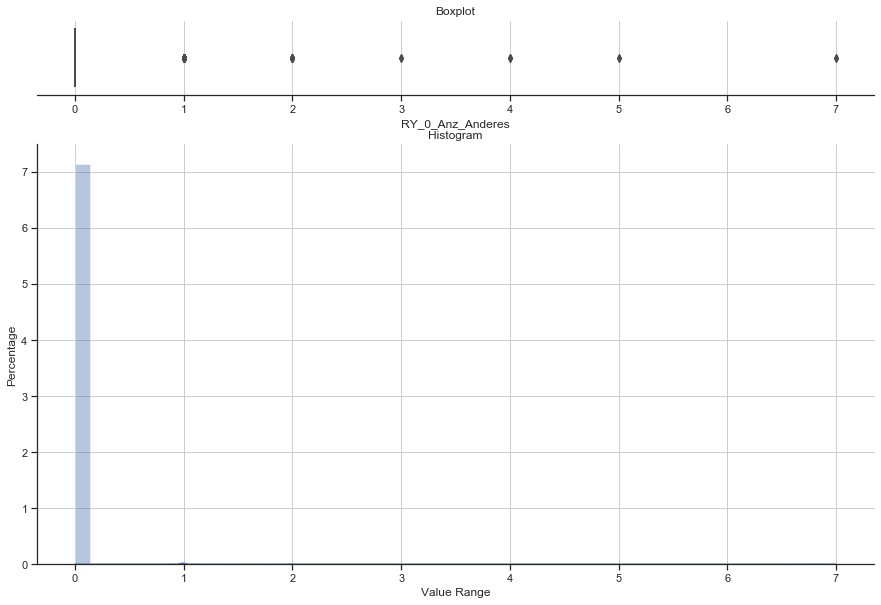

RY_1_Anz_Anderes


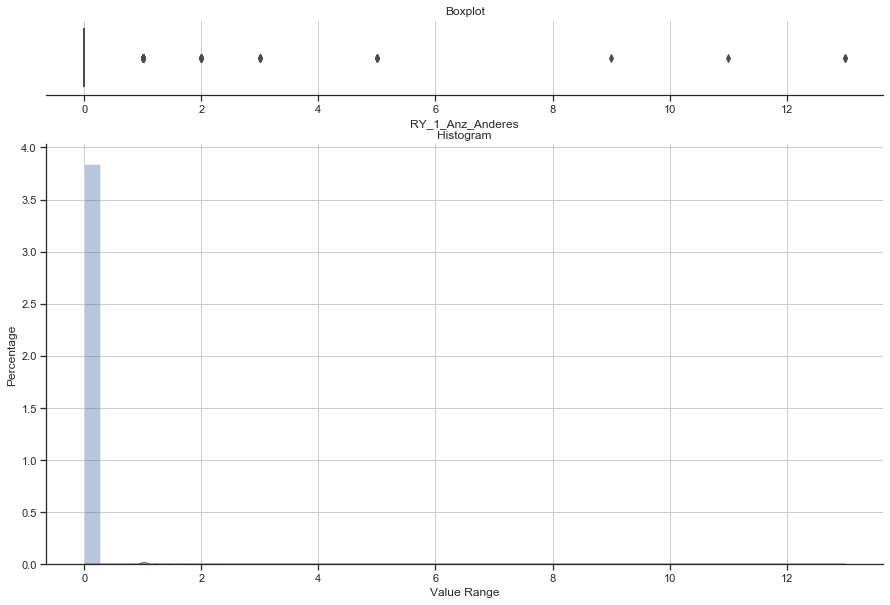

RY_2_Anz_Anderes


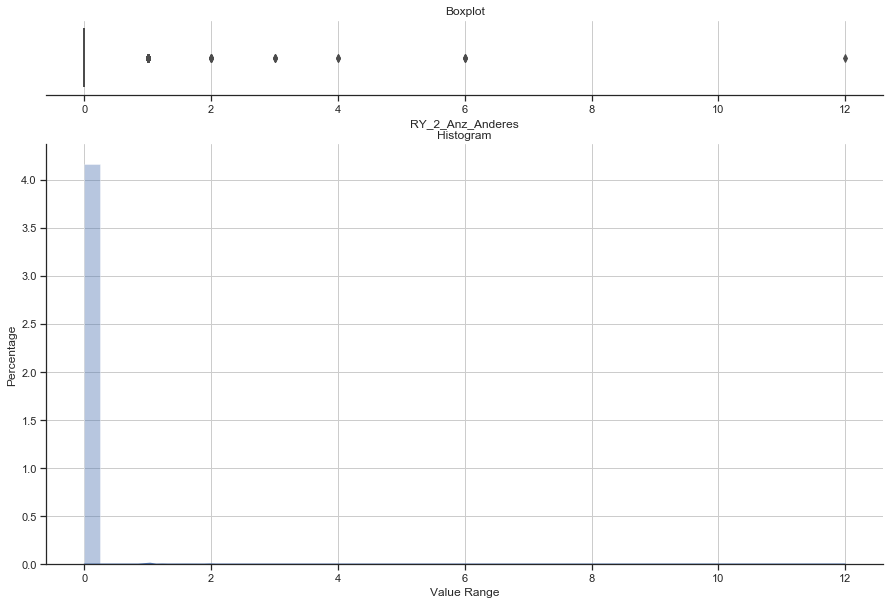

RY_3_Anz_Anderes


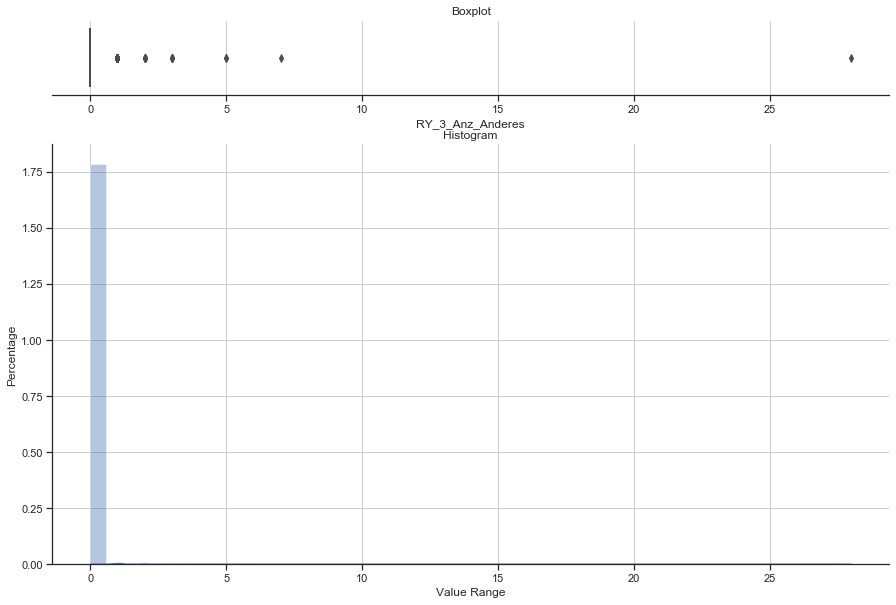

Letzter_Kontakt_Delta_Anderes


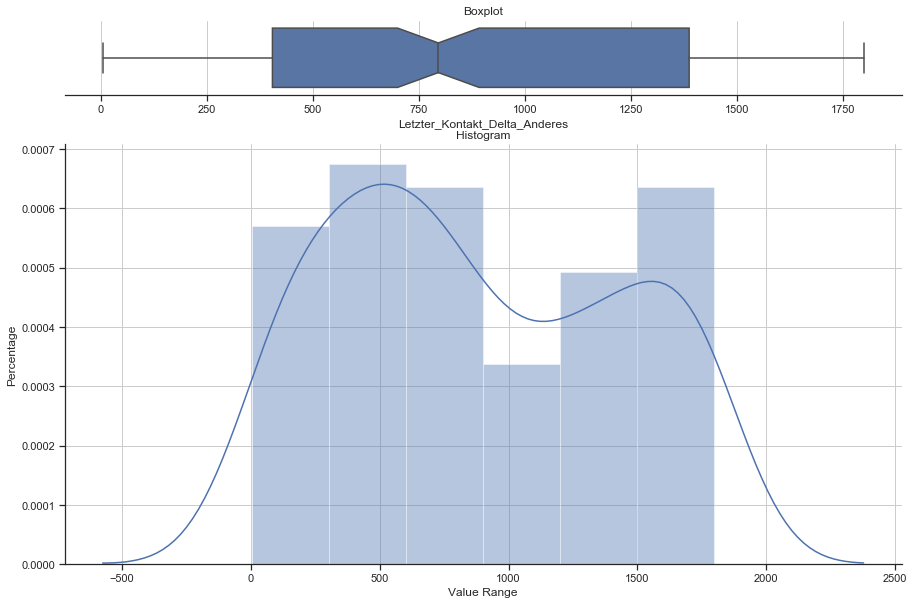

Letzter_Kontakt_Delta_Besprechung


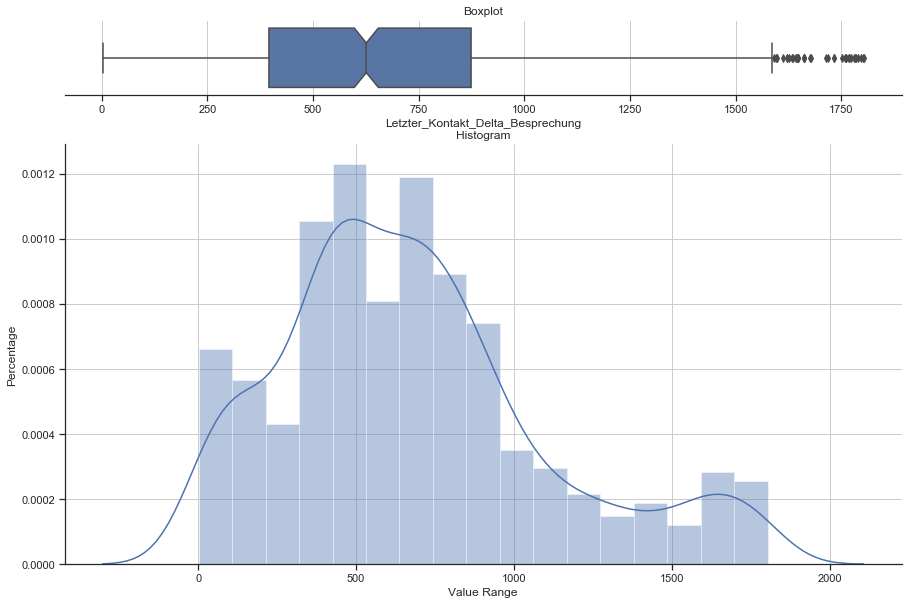

Letzter_Kontakt_Delta_Besuch


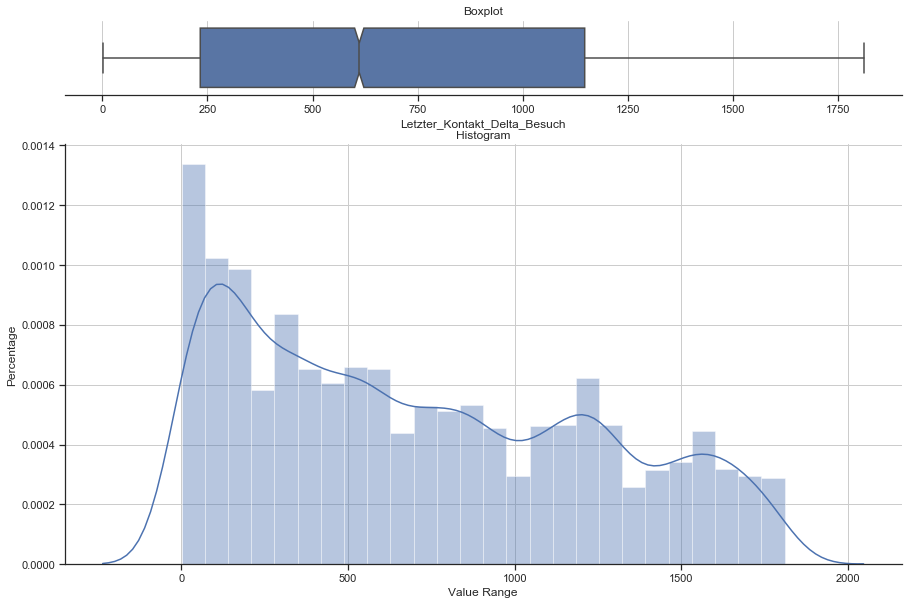

Letzter_Kontakt_Delta_Brief_Dankeskarte


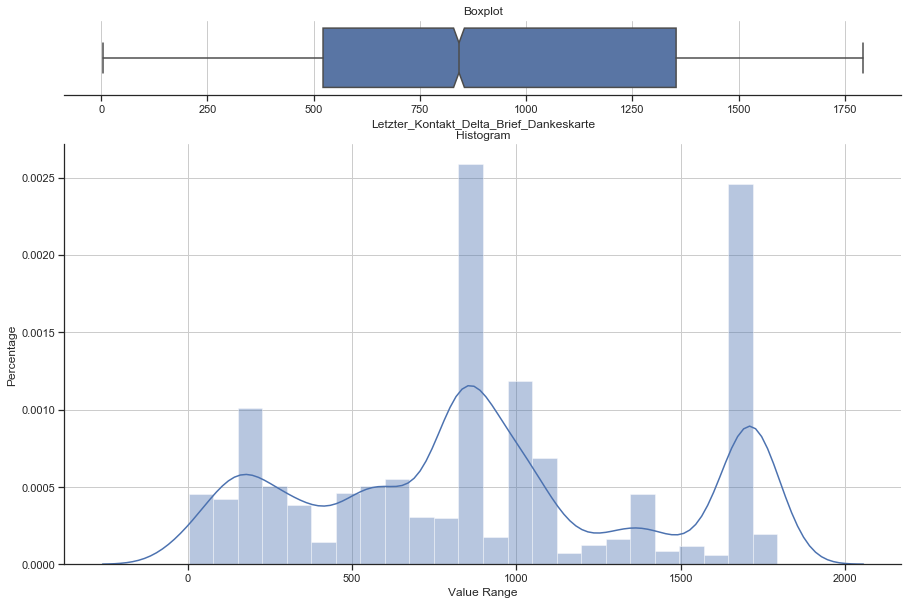

Letzter_Kontakt_Delta_E-Mail


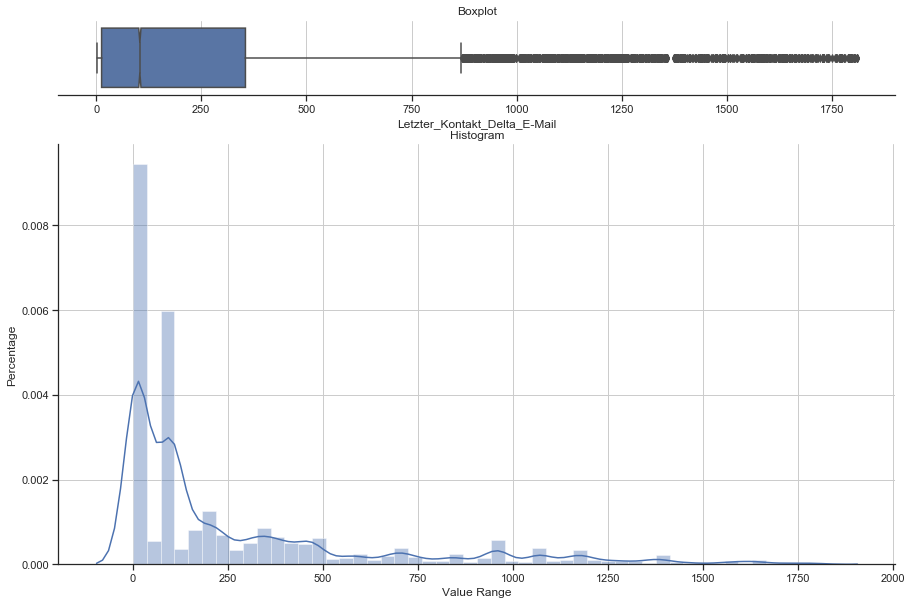

Letzter_Kontakt_Delta_Event_Veranstaltung


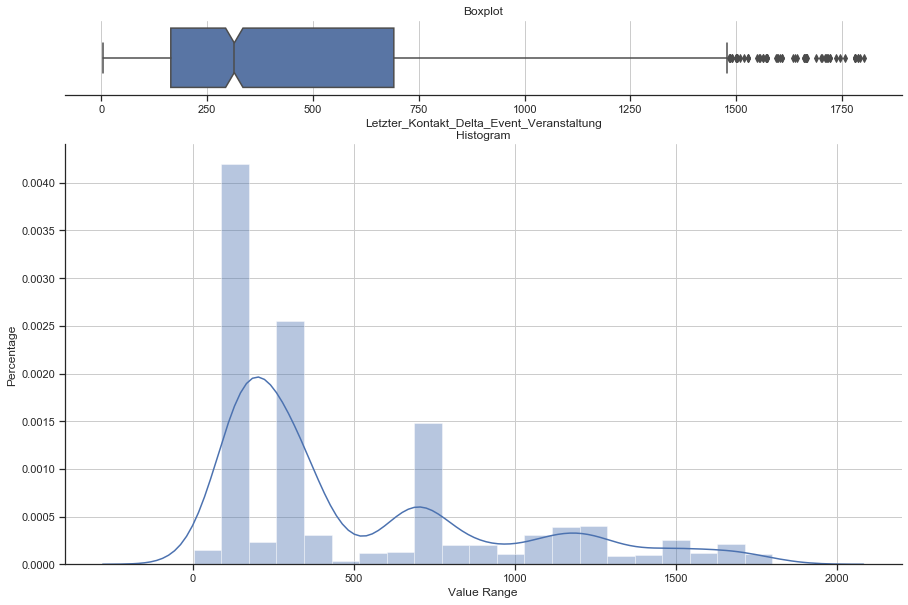

Letzter_Kontakt_Delta_Telefon


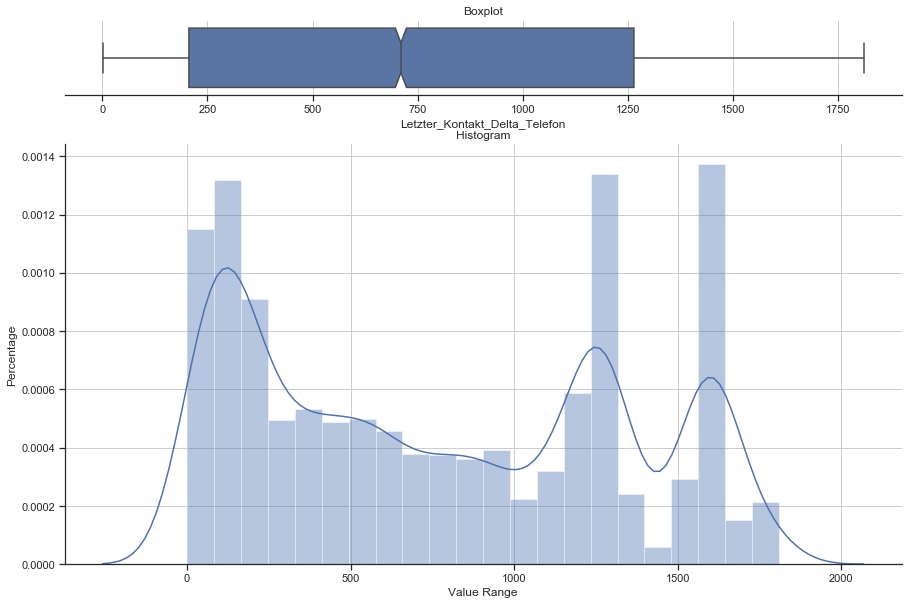

Letzter_Kontakt_Delta_global


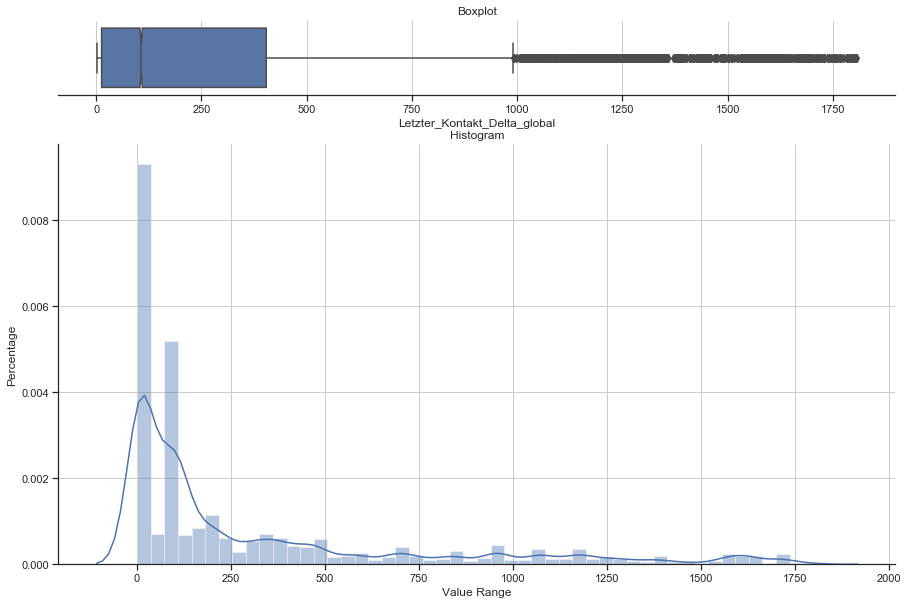

In [35]:
lazy_bxplt_hstgrm(crm_train_df)

In [ ]:
crm_train_df.iloc[:,28:].describe()

In [ ]:
2181/365